In [1]:
import os
os.chdir("..")
import json
import torch

from matplotlib import pyplot as plt
from torcheval.metrics.functional import binary_auprc

import utils
import metrics
import data_utils

c:\Users\tuoma\miniconda3\envs\pytorch2\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
c:\Users\tuoma\miniconda3\envs\pytorch2\Lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\tuoma\miniconda3\envs\pytorch2\Lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints a

## Test parameters

In [ ]:
device = "cuda"
batch_size = 256
activations_dir = 'saved_activations'
epsilon = 0.001
n_samples = 1 #how many different samples for c_t^+/c_t^- we take

concept_perturbation = "semantic" #"random", semantic means utilizing real superclasses, random is the typical test scenario

In [3]:
dataset_name = "imagenet_val"
target_name = "vit_b_16_imagenet"
target_layer = "heads"
activation_fn = "softmax"
superclass_concepts = False
superclass_neurons = False
single_class_neurons = True
final_layer = True
test_alpha = "best"

In [4]:
model, preprocess = data_utils.get_target_model(target_name, device=device)
dataset = data_utils.get_data(dataset_name, preprocess)
if dataset_name != "openwebtext_subset":
    pil_data = data_utils.get_data(dataset_name)

In [5]:
if dataset_name == "cub_test":
    concept_activations, text = utils.get_cub_concept_labels(dataset, device, batch_size)
    neuron_activations = utils.get_cub_concept_preds(model, dataset, device, batch_size)
elif dataset_name == "openwebtext_subset":
    concept_activations, neuron_activations = utils.get_llm_ct_ak(model, dataset, device, batch_size)
else:
    concept_activations, text = utils.get_onehot_labels(dataset_name, device, superclass_concepts)
    layer_save_path = '{}/{}_{}/{}/'.format(activations_dir, target_name, dataset_name, target_layer)
    neuron_activations = utils.save_summary_activations(model, dataset, device, target_layer, batch_size, layer_save_path)


if activation_fn == "softmax":
    neuron_activations = torch.nn.functional.softmax(neuron_activations, dim=1)
elif activation_fn == "sigmoid":
    neuron_activations = torch.nn.functional.sigmoid(neuron_activations)
torch.cuda.empty_cache()

print(concept_activations.shape, neuron_activations.shape)

torch.Size([50000, 1000]) torch.Size([50000, 1000])


In [6]:
#check prediction accuracy to make sure loading works, only works for some settings
#print(torch.mean((neuron_activations > 0.5).float() == concept_activations, dtype=float))

Top concepts:
American alligator tensor(1.)
tench tensor(0.)
goldfish tensor(0.)
great white shark tensor(0.)
tiger shark tensor(0.)


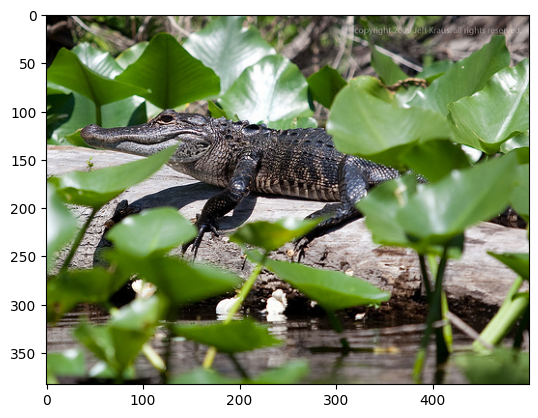

In [7]:
if dataset_name != "openwebtext_subset":
    #check to see inputs and concept labels loaded correctly
    img_id = 2500
    plt.imshow(pil_data[img_id][0])
    vals, ids = torch.sort(concept_activations[img_id], descending=True)
    print("Top concepts:")
    for id in ids[:5]:
        print(text[id], concept_activations[img_id, id].cpu())

In [8]:
#creating superclass neurons, only for imagenet final layer
if superclass_neurons:
    assert(final_layer==True)
    assert(dataset_name=="imagenet_val")
    with open('data/imagenet_superclass_to_ids.json', 'r') as f:
        superclass_to_id = json.load(f)
    
    new_activations = []
    for sclass in superclass_to_id.keys():
        subclasses = superclass_to_id[sclass]
        new_activations.append(torch.sum(torch.stack([neuron_activations[:, i] for i in subclasses], dim=0), dim=0))
    new_activations = torch.stack(new_activations, dim=1)
    print(neuron_activations.shape, new_activations.shape)
    neuron_activations = torch.cat([neuron_activations, new_activations], dim=1)

if final_layer:
    correct = torch.arange(neuron_activations.shape[1])
else:
    #explanation is the concept that maximizes IoU
    similarities = metrics.iou(neuron_activations, concept_activations, alpha=test_alpha)
    correct = torch.argmax(similarities, dim=1)

In [9]:
if not single_class_neurons:
    neuron_activations = neuron_activations[:, 1000:]
    correct = correct[1000:]

In [10]:
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### Split neurons into 5% validation and 95% test set

In [11]:
num_classes = concept_activations.shape[1]
neurons = torch.randperm(neuron_activations.shape[1])
val_neurons = neurons[:int(0.05*len(neurons))].sort()[0]
val_correct = correct[val_neurons]
val_correct = torch.nn.functional.one_hot(val_correct, num_classes=num_classes).to(device)

test_neurons = neurons[int(0.05*len(neurons)):].sort()[0]
test_correct = correct[test_neurons]
test_correct = torch.nn.functional.one_hot(test_correct, num_classes=num_classes).to(device)

In [12]:
with open('data/imagenet_superclass_to_ids.json', 'r') as f:
    superclass_to_id = json.load(f)

def find_closest_superclass(class_id):
    best_name = None
    best_ids = None
    best_size = 10000
    for sclass in superclass_to_id:
        if class_id in superclass_to_id[sclass]:
            if len(superclass_to_id[sclass]) < best_size:
                best_name = sclass
                best_ids = superclass_to_id[sclass]
                best_size = len(superclass_to_id[sclass])
    return best_ids, best_name, best_size

test_id = 30
print(text[test_id])
best_ids, best_name, best_size = find_closest_superclass(test_id)
print(best_ids, best_name, best_size)

American bullfrog
[30, 31, 32] frog 3


In [13]:
if concept_perturbation == "semantic":
    concepts_extra = []

    for class_id in range(neuron_activations.shape[1]):
        sclass_ids, _, _ = find_closest_superclass(class_id)
        concepts_extra.append(torch.sum(concept_activations[:, sclass_ids], dim=1, keepdims=True))
    concepts_extra = torch.cat(concepts_extra, dim=1)
    concepts_extra = [concepts_extra]
    print(torch.mean(torch.sum(concepts_extra[0], dim=0)/torch.sum(concept_activations, dim=0)))

elif concept_perturbation == "random":
    concepts_extra = []
    for _ in range(n_samples):
        cutoff = torch.sum(concept_activations, dim=0, keepdims=True)/(concept_activations.shape[0]-torch.sum(concept_activations, dim=0, keepdims=True))
        extra = torch.rand(concept_activations.shape, device=device) < cutoff
        concepts_extra.append(torch.clamp(concept_activations + extra, max=1).cpu())

tensor(13.4370, device='cuda:0')


## Testing different methods

In [14]:
def print_results(extra_diff):
    extra_reduced = torch.mean((extra_diff<-epsilon).float())*100
    print("Extra Labels Test: Avg Score Diff:{:.4f}, Decrease Acc: {:.2f}%".format(extra_diff.mean(), extra_reduced))

def run_test(explanation_fn, min_val=None, max_val=None):
    similarities = explanation_fn(neuron_activations[:, test_neurons], concept_activations)
    auc = binary_auprc(similarities.flatten(), test_correct.flatten())
    print("Test AUPRC: {:.7f}".format(auc))

    correct_sims = torch.sum(similarities*test_correct, dim=1)

    extra_c_sims = []
    corr_extra_c_sims = []
    for c_extra in concepts_extra:
        extra_c_sim = explanation_fn(neuron_activations[:, test_neurons], c_extra.to(device))
        extra_c_sims.append(extra_c_sim)
        corr_extra_c_sims.append(torch.sum(extra_c_sim*test_correct, dim=1))
    
    if min_val==None:
        min_val = torch.min(torch.cat([similarities]+extra_c_sims, dim=0))
    if max_val==None:
        max_val = torch.max(torch.cat([similarities]+extra_c_sims, dim=0))

    print("Original avg:{:.4f}".format(torch.mean(correct_sims)))
    #average across samples
    corr_extra_c_sims = torch.mean(torch.stack(corr_extra_c_sims, dim=0), dim=0)

    extra_diff = (corr_extra_c_sims-correct_sims)/(max_val-min_val)
    print_results(extra_diff)
    
def fast_sims(explanation_fn, concept_acts):
    correct_ids = torch.argmax(test_correct, dim=1)
    correct_sims = []
    for i in range(len(test_neurons)):
        sims = explanation_fn(neuron_activations[:, test_neurons[i]:test_neurons[i]+1],
                                            concept_acts[:, correct_ids[i]:correct_ids[i]+1])
        correct_sims.append(sims[0,0])
    correct_sims = torch.stack(correct_sims, dim=0)
    return correct_sims

def run_test_fast(explanation_fn, min_val, max_val):
    correct_sims = fast_sims(explanation_fn, concept_activations)

    corr_extra_c_sims = []
    for c_extra in concepts_extra:
        corr_extra_c_sims.append(fast_sims(explanation_fn, c_extra.to(device)))
    corr_extra_c_sims = torch.mean(torch.stack(corr_extra_c_sims, dim=0), dim=0)
    extra_diff = (corr_extra_c_sims-correct_sims)/(max_val-min_val)
    print_results(extra_diff)

def find_best_alpha(explanation_fn, min_val=None, max_val=None, use_fast=False, test_alpha=test_alpha):
    """
    for fns with only an alpha parameter
    """
    
    if test_alpha == "best":
        best_auc = -1
        best_alpha = 0
        for alpha in [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]:
            similarities = explanation_fn(neuron_activations[:, val_neurons], concept_activations, alpha=alpha)
            auc = binary_auprc(similarities.flatten(), val_correct.flatten())
            if auc > best_auc:
                best_auc = auc
                best_alpha = alpha
                #print("Alpha: {}, Val AUC: {:.7f}".format(alpha, auc))
        print("Best Alpha: {}".format(best_alpha))
    else:
        best_alpha = test_alpha
        print("Using Alpha = {}".format(best_alpha))

    if use_fast:
        run_test_fast(explanation_fn=lambda x, y: explanation_fn(x, y, alpha=best_alpha),
                        min_val=min_val, max_val=max_val)
    else:
        run_test(explanation_fn=lambda x, y: explanation_fn(x, y, alpha=best_alpha),
                        min_val=min_val, max_val=max_val)

def find_best_alpha_lam(explanation_fn, min_val=None, max_val=None, test_alpha=test_alpha):
    best_auc = -1
    if test_alpha == "best":
        best_alpha = 0
        best_lam = 0
        for alpha in [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]:
            for lam in [0.01*i for i in range(101)]:
                similarities = explanation_fn(neuron_activations[:, val_neurons], concept_activations, alpha=alpha, lam=lam)
                auc = binary_auprc(similarities.flatten(), val_correct.flatten())
                if auc > best_auc:
                    best_auc = auc
                    best_alpha = alpha
                    best_lam = lam
                    #print("alpha={}, lam={}, Val AUC: {:.7f}".format(alpha, lam, auc))
        print("Best alpha={}, Best lam={}".format(best_alpha, best_lam))
    else:
        best_lam = 0
        best_alpha = test_alpha
        for lam in [0.01*i for i in range(101)]:
            similarities = explanation_fn(neuron_activations[:, val_neurons], concept_activations, alpha=test_alpha, lam=lam)
            auc = binary_auprc(similarities.flatten(), val_correct.flatten())
            if auc > best_auc:
                best_auc = auc
                best_lam = lam
        print("Best alpha={}, Best lam={}".format(best_alpha, best_lam))
    
    run_test(explanation_fn=lambda x, y: explanation_fn(x, y, alpha=best_alpha, lam=best_lam),
                       min_val=min_val, max_val=max_val)


### Recall

In [15]:
find_best_alpha(metrics.recall, min_val=0, max_val=1)

Best Alpha: 0.0001
Test AUPRC: 0.9988765
Original avg:0.9520
Extra Labels Test: Avg Score Diff:0.0189, Decrease Acc: 0.00%


### Precision

In [16]:
find_best_alpha(metrics.precision, min_val=0, max_val=1)

Best Alpha: 0.0001
Test AUPRC: 0.9988765
Original avg:0.0952
Extra Labels Test: Avg Score Diff:-0.0698, Decrease Acc: 99.79%


### F1-score

In [17]:
find_best_alpha(metrics.f1_score, min_val=0, max_val=1)

Best Alpha: 0.0001
Test AUPRC: 0.9988765
Original avg:0.1731
Extra Labels Test: Avg Score Diff:-0.1242, Decrease Acc: 99.79%


### IoU

In [18]:
find_best_alpha(metrics.iou, min_val=0, max_val=1)

Best Alpha: 0.0001
Test AUPRC: 0.9988765
Original avg:0.0949
Extra Labels Test: Avg Score Diff:-0.0695, Decrease Acc: 99.79%


### Accuracy

In [19]:
find_best_alpha(metrics.accuracy, min_val=0, max_val=1)

Best Alpha: 0.0001
Test AUPRC: 0.9988765
Original avg:0.9991
Extra Labels Test: Avg Score Diff:-0.0124, Decrease Acc: 71.37%


### Balanced Accuracy

In [20]:
find_best_alpha(metrics.balanced_accuracy, min_val=0, max_val=1)

Best Alpha: 0.0001
Test AUPRC: 0.9988765
Original avg:0.9755
Extra Labels Test: Avg Score Diff:0.0033, Decrease Acc: 64.53%


### Inverse Balanced Accuracy

In [21]:
find_best_alpha(metrics.inverse_balanced_accuracy, min_val=0, max_val=1)

Best Alpha: 0.0001
Test AUPRC: 0.9988765
Original avg:0.5476
Extra Labels Test: Avg Score Diff:-0.0349, Decrease Acc: 99.79%


### AUC

In [22]:
find_best_alpha(metrics.auc, min_val=0, max_val=1, use_fast=True)

Best Alpha: 0.0005
Extra Labels Test: Avg Score Diff:0.0075, Decrease Acc: 44.84%


### Inverse AUC (Classification)

In [23]:
run_test_fast(metrics.inverse_auc, min_val=0, max_val=1)

Extra Labels Test: Avg Score Diff:-0.2110, Decrease Acc: 96.00%


### Correlation

In [24]:
run_test(metrics.correlation, min_val=-1, max_val=1)

Test AUPRC: 0.9997781
Original avg:0.8477
Extra Labels Test: Avg Score Diff:-0.2074, Decrease Acc: 99.58%


### Correlation top-and-random

In [25]:
run_test(metrics.correlation_top_and_random, min_val=-1, max_val=1)

Test AUPRC: 0.9993304
Original avg:0.8228
Extra Labels Test: Avg Score Diff:-0.0331, Decrease Acc: 70.63%


### Spearman Correlation

In [26]:
run_test(metrics.spearman_correlation, min_val=-1, max_val=1)

Test AUPRC: 0.0021514
Original avg:0.0029
Extra Labels Test: Avg Score Diff:0.0023, Decrease Acc: 20.53%


### Spearman Correlation top-and-random

In [27]:
run_test(metrics.spearman_correlation_top_and_random, min_val=-1, max_val=1)

Test AUPRC: 0.6541993
Original avg:0.4819
Extra Labels Test: Avg Score Diff:0.0296, Decrease Acc: 35.47%


### Cosine

In [28]:
run_test(metrics.cos_sim, min_val=-1, max_val=1)

Test AUPRC: 0.9997782
Original avg:0.8479
Extra Labels Test: Avg Score Diff:-0.2065, Decrease Acc: 99.58%


### WPMI

In [29]:
find_best_alpha_lam(metrics.wpmi)

Best alpha=0.0001, Best lam=0.0
Test AUPRC: 0.9988765
Original avg:-0.8842
Extra Labels Test: Avg Score Diff:0.0189, Decrease Acc: 0.00%


### MAD (Mean Activation Difference)

In [30]:
run_test(metrics.mad)

Test AUPRC: 0.9994145
Original avg:0.6728
Extra Labels Test: Avg Score Diff:-0.5423, Decrease Acc: 100.00%


### AUPRC

In [31]:
#slower than others
find_best_alpha(metrics.auprc, min_val=0, max_val=1, use_fast=True)

Best Alpha: 0.0001
Extra Labels Test: Avg Score Diff:-0.0672, Decrease Acc: 99.37%


### Inverse AUPRC

In [32]:
run_test_fast(metrics.inverse_auprc, min_val=0, max_val=1)

Extra Labels Test: Avg Score Diff:-0.4799, Decrease Acc: 97.37%
